# **NLP Project: Dataset Preprocessing**

*Master in Machine Learning for Health, 2023~2024*

*Authors: Daniel Corrales, Jaime Fernández & Rafael Rodríguez*

---

In [4]:
import pandas as pd
import spacy
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# For fancy table Display
%load_ext google.colab.data_table

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
nlp = spacy.load('en_core_web_sm')

The raw scraped data has to be further preprocessed:
1. Clean DataFrame: remove duplicate rows and rows containing NaN values.
2. Remove salary information from decription column.
3. Convert to salary per year and create new target column `avg_pay`, this is the target variable to be predicted by the NLP model.
4. Remove pay columns.
5. Combine all info into the same text with format:

  `Job title | Company name | Location | Job type (if provided) | Description`

### Data Loading

In [23]:
path = '/content/drive/MyDrive/NLP/Project/'

dfs = []

for filename in os.listdir(path):
    if filename.endswith('.csv'):
      print(filename)
      file_path = os.path.join(path, filename)
      df = pd.read_csv(file_path)
      dfs.append(df)

engineering_jobs.csv
AI_jobs.csv
research_jobs.csv
finance_jobs.csv
sales_jobs.csv
legal_jobs.csv
HR_jobs.csv
marketing_jobs.csv
consultant_jobs.csv


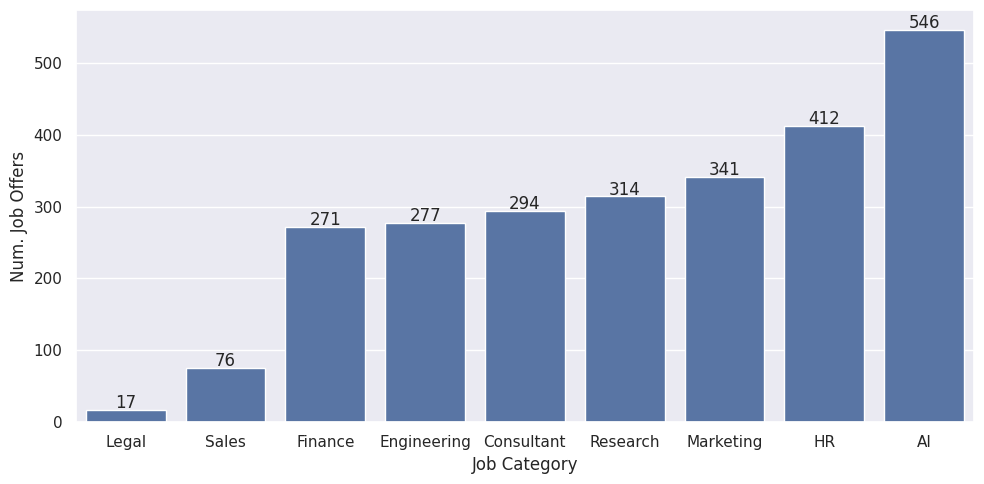

In [24]:
# Plot distribution
names = ['Engineering', 'AI', 'Research', 'Finance', 'Sales', 'Legal', 'HR', 'Marketing', 'Consultant']
df_lengths = {}

# Calculate length of each DataFrame
for i, df in enumerate(dfs):
    df_lengths[names[i]] = len(df)

# Convert dictionary to DataFrame for easier plotting
length_df = pd.DataFrame(list(df_lengths.items()), columns=['DataFrame', 'Num. Job Offers']).sort_values(by='Num. Job Offers')

# Create bar plot using Seaborn
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=length_df, x='DataFrame', y='Num. Job Offers')
plt.xlabel('Job Category')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.savefig(path + 'dataset.png', dpi=500)
plt.show()

In [25]:
# Concat all csv
df = pd.concat(dfs, ignore_index=True)
og_shape = df.shape[0]
print(f"Total numer of jobs before cleaning: {og_shape}")

Total numer of jobs before cleaning: 2548


In [ ]:
df.head(1)

,title,company_name,location,pay,job_type,description
0,Electrical Engineering: Opportunities for Univ...,Microsoft,"One Microsoft Way, Redmond, WA 98052","$76,400 - $151,800 por año",Full-time,"Come build community, explore your passions an..."


### 1. Clean DataFrame

In [ ]:
df = df.drop_duplicates()
df = df.dropna()
print(f"Total number of jobs after cleaning: {df.shape[0]}")
print(f"Number of jobs removed: {og_shape - df.shape[0]}")

Total number of jobs after cleaning: 2270
Number of jobs removed: 278


### 2. Remove Salary Information from Description

In [ ]:
def remove_salary(text):
  doc = nlp(text)
  filtered_sents = [sent.text for sent in doc.sents if "$" not in sent.text]
  filtered_text = " ".join(filtered_sents)

  return filtered_text

In [ ]:
# Apply the function to the 'description' column
df['description'] = df['description'].apply(remove_salary)
df.head(1)

,title,company_name,location,pay,job_type,description
0,Electrical Engineering: Opportunities for Univ...,Microsoft,"One Microsoft Way, Redmond, WA 98052","$76,400 - $151,800 por año",Full-time,"Come build community, explore your passions an..."


### 3. Salary/hour to Salary/year and Create Target Columns

In [ ]:
def process_salary(text):
  hours_week = 40 # Assume typical working schedule
  weeks_year = 52
  days_week = 5

  doc = nlp(text.lower())
  texts = [token.text for token in doc]
  digits = [float(token.text.replace(',','')) for token in doc if token.text.replace(',', '').replace('.','').isdigit()]

  min = np.min(digits)
  max = np.max(digits)

  if 'hora' in texts: # Convert to salary per year
    min *= hours_week * weeks_year
    max *= hours_week * weeks_year

  elif 'mes' in texts: # Convert to salary per year
    min *= 12
    max *= 12

  elif 'semana' in texts: # Convert to salary per year
    min *= 52
    max *= 52

  elif 'dia' in texts or 'día' in texts: # Convert to salary per year
    min *= days_week * weeks_year
    max *= days_week * weeks_year

  return np.mean([min, max])

In [ ]:
df['avg_pay'] = df['pay'].map(process_salary)
df.head(1)

,title,company_name,location,pay,job_type,description,avg_pay
0,Electrical Engineering: Opportunities for Univ...,Microsoft,"One Microsoft Way, Redmond, WA 98052","$76,400 - $151,800 por año",Full-time,"Come build community, explore your passions an...",114100.0


### 4. Remove Pay Column

In [ ]:
df = df.drop(columns=['pay'])
df.head(1)

,title,company_name,location,job_type,description,avg_pay
0,Electrical Engineering: Opportunities for Univ...,Microsoft,"One Microsoft Way, Redmond, WA 98052",Full-time,"Come build community, explore your passions an...",114100.0


### 5. Join Information in One Text

In [ ]:
df['full_info'] = df.apply(lambda row: f"Job title: {row['title']}. Company name: {row['company_name']}. \
                                        Location: {row['location']}. Job type: {row['job_type']}. {row['description']}", axis=1)
df.head(1)

,title,company_name,location,job_type,description,avg_pay,full_info
0,Electrical Engineering: Opportunities for Univ...,Microsoft,"One Microsoft Way, Redmond, WA 98052",Full-time,"Come build community, explore your passions an...",114100.0,Job title: Electrical Engineering: Opportuniti...


### Save DataFrame

In [ ]:
df['avg_pay'].describe()

count      2270.000000
mean     112621.154581
std       63449.777966
min       27040.000000
25%       69817.170000
50%       93146.000000
75%      136937.250000
max      750000.000000
Name: avg_pay, dtype: float64

In [ ]:
print(f"Saving {df.shape[0]} jobs...")
df.to_csv(path + 'processed/' + 'jobs_processed.csv', index=False)

Saving 2270 jobs...
